In [1]:
import torch
import torch.nn as nn
import pandas as pd
from nltk import TweetTokenizer

In [2]:
df = pd.read_csv('../../data/Airline_sentiment_raw.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state= 12)

In [5]:
e = LabelEncoder()
y_train = e.fit_transform(df_train['airline_sentiment'])
y_test = e.transform(df_test['airline_sentiment'])

In [6]:
e.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [7]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 7302, 1: 2530, 2: 1880})
Counter({0: 1876, 1: 569, 2: 483})


In [8]:
tweettk = TweetTokenizer()
df_train['tokenized_text'] = df_train.apply(lambda x: tweettk.tokenize(x['text']), axis = 1)
df_test['tokenized_text'] = df_test.apply(lambda x: tweettk.tokenize(x['text']), axis = 1)
def identity_tokenizer(text):
    return text

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), tokenizer=identity_tokenizer, lowercase=False)
corpus = list(df_train['tokenized_text'])
X_train = vectorizer.fit_transform(corpus)
X_test = vectorizer.transform(list(df_test['tokenized_text']))

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
vectorizer.get_feature_names_out()
print(len(vectorizer.get_feature_names_out()))

283906


In [13]:
import numpy as np
idx = np.argwhere(X_train.toarray()[3]>0)[:,0]
vectorizer.get_feature_names_out()[idx]

array(['!', ',', ", I've", ", I've tried", '-', '- help', '- help !', '.',
       ". I'm", ". I'm having", '30', '30 EST', '30 EST .', '8',
       '8 times', '8 times today', '8:', '8: 30', '8: 30 EST',
       '@AmericanAir', '@AmericanAir ,', "@AmericanAir , I've", 'EST',
       'EST .', "EST . I'm", "I'm", "I'm having", "I'm having no", "I've",
       "I've tried", "I've tried no", 'at', 'at 8:', 'at 8: 30',
       'beginning', 'beginning at', 'beginning at 8:', 'desk',
       'desk beginning', 'desk beginning at', 'get', 'get in',
       'get in touch', 'having', 'having no', 'having no luck', 'help',
       'help !', 'in', 'in touch', 'in touch with', 'less', 'less than',
       'less than 8', 'luck', 'luck -', 'luck - help', 'no', 'no less',
       'no less than', 'no luck', 'no luck -', 'service', 'service desk',
       'service desk beginning', 'than', 'than 8', 'than 8 times',
       'times', 'times today', 'times today to', 'to', 'to get',
       'to get in', 'today', 'today t

# Model selection

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
(lr.predict(X_train)==y_train).mean()

0.9090676229508197

In [17]:
(lr.predict(X_test)==y_test).mean()

0.7824453551912568

In [18]:
idx = np.argpartition(-abs(lr.coef_), kth=3, axis=1)[:,:3]

In [19]:
lr.coef_[0,idx[2]]

array([-3.09653321,  0.59631965, -3.25031483])

In [20]:
vectorizer.get_feature_names_out()[idx[2]]

array(['thanks', '?', '!'], dtype=object)

## Eval

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
y_test_pred = lr.predict(X_test)

In [23]:
confusion_matrix(y_test, y_test_pred, normalize='true')

array([[0.97121535, 0.01492537, 0.01385928],
       [0.5483304 , 0.37258348, 0.07908612],
       [0.41407867, 0.05383023, 0.5320911 ]])

In [24]:
e.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [25]:
lr.predict_proba(X_test)

array([[0.79007142, 0.10443285, 0.10549574],
       [0.11739281, 0.03074196, 0.85186523],
       [0.89220935, 0.08586487, 0.02192578],
       ...,
       [0.2213164 , 0.07865532, 0.70002828],
       [0.75733589, 0.2098197 , 0.0328444 ],
       [0.80535415, 0.15707137, 0.03757448]])

* Classified too many neutral/positive to negative

# Modeling with negative prediction only

In [26]:
y_neg_train = (y_train>=1)
y_neg_test = (y_test>=1)

In [27]:
lr_neg = LogisticRegression()

In [28]:
lr_neg.fit(X_train, y_neg_train)

LogisticRegression()

In [29]:
y_neg_test_pred = lr_neg.predict(X_test)

In [30]:
confusion_matrix(y_neg_test, y_neg_test_pred, normalize='true')

array([[0.96375267, 0.03624733],
       [0.43060837, 0.56939163]])

In [31]:
y_neg_test_prob = lr_neg.predict_proba(X_test)

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

In [33]:
fpr, tpr, thd = roc_curve(y_neg_test, y_neg_test_prob[:,1])
roc_auc_score(y_neg_test, y_neg_test_prob[:,1])

0.9066300254566386

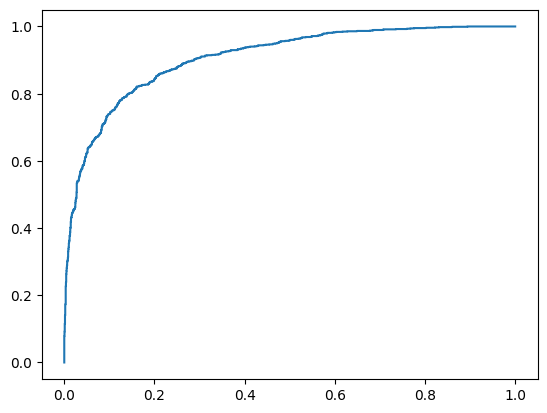

In [34]:
from matplotlib import pyplot as plt
plt.plot(fpr, tpr)

In [35]:
y_neg_train_prob = lr_neg.predict_proba(X_train)
fpr, tpr, thd = roc_curve(y_neg_train, y_neg_train_prob[:,1])
roc_auc_score(y_neg_train, y_neg_train_prob[:,1])

0.9875730936947043

In [36]:
y_neg_test_pred

array([False,  True, False, ...,  True, False, False])

(array([549., 705., 448., 330., 243., 195., 142., 148.,  97.,  71.]),
 array([0.01290418, 0.11153156, 0.21015895, 0.30878633, 0.40741372,
        0.50604111, 0.60466849, 0.70329588, 0.80192326, 0.90055065,
        0.99917804]),
 <BarContainer object of 10 artists>)

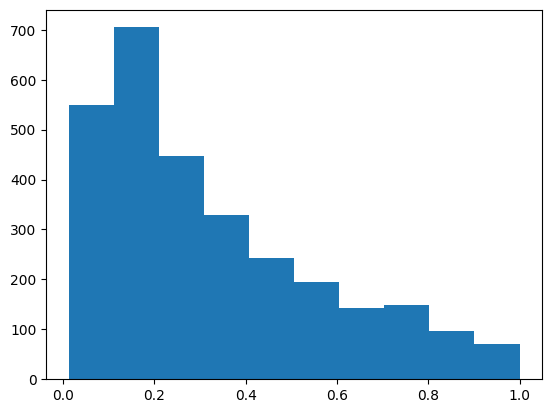

In [45]:
plt.hist(y_neg_test_prob[:,1])

In [53]:
pcts = np.percentile(y_neg_test_prob[:,1], [10*i for i in range(11)])

In [57]:
pcts

array([0.01290418, 0.07978389, 0.11576955, 0.15196885, 0.19568545,
       0.25060885, 0.32498184, 0.41376041, 0.53608439, 0.71536293,
       0.99917804])

In [75]:
plot_x = []
plot_y = []
for i in range(10):
    plot_x.append(y_neg_test_prob[(y_neg_test_prob[:,1]<pcts[i+1]) & (y_neg_test_prob[:,1]>=pcts[i]), 1].mean())
    plot_y.append(y_neg_test[(y_neg_test_prob[:,1]<pcts[i+1]) & (y_neg_test_prob[:,1]>=pcts[i])].mean())

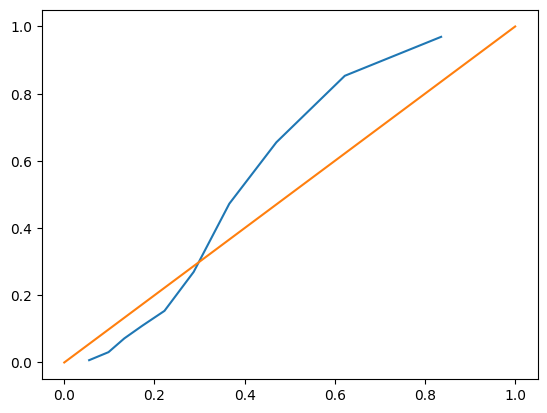

In [78]:
plt.plot(plot_x, plot_y)
plt.plot([i/10.0 for i in range(11)], [i/10.0 for i in range(11)])

In [38]:
Counter(y_test)

Counter({0: 1876, 2: 483, 1: 569})

# XGBoost

In [38]:
import xgboost as xgb

In [39]:
params = {'n_estimators': 100,
          'max_depth': 3,
          'learning_rate': 0.1,
          'objective': 'binary:logistic',
          'booster': 'gbtree',
          'n_jobs': 4,
          'subsample': 1,
          'colsample_bytree': 1,
          'random_state': 0,
          'reg_lambda': 1,
          'eval_metric': ['auc', 'logloss']
         }

In [40]:
xgb_clf = xgb.XGBClassifier(**params)

In [41]:
xgb_clf.fit(X_train, y_neg_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['auc', 'logloss'], feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=4,
              num_parallel_tree=None, random_state=0, ...)

In [42]:
(xgb_clf.predict(X_train)==y_neg_train).mean()

0.8027663934426229

In [43]:
(xgb_clf.predict(X_test)==y_neg_test).mean()

0.7786885245901639

In [44]:
y_neg_test_prob = xgb_clf.predict_proba(X_test)[:,1]

In [45]:
fpr, tpr, thd = roc_curve(y_neg_test, y_neg_test_prob)
roc_auc_score(y_neg_test, y_neg_test_prob)

0.8535647907934526

## model selection

In [46]:
from sklearn.model_selection import KFold, GridSearchCV

In [47]:
params = {'objective': 'binary:logistic',
          'eval_metric':'logloss',
          'booster': 'gbtree',
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'random_state': 0,
         }

params_grid = {'n_estimators': [40, 80, 120, 160],
               'max_depth': [3,4],
               'learning_rate': [0.1, 0.5],
               'reg_lambda': [1,5],
              }

In [48]:
clf = GridSearchCV(xgb_clf, params_grid, n_jobs=4, verbose=2, scoring=['roc_auc','accuracy','neg_log_loss'], refit='roc_auc')

In [49]:
clf.fit(X_train, y_neg_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=40, reg_lambda=1; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=40, reg_lambda=5; total time=   2.0s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=80, reg_lambda=1; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=80, reg_lambda=1; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=80, reg_lambda=5; total time=   3.6s


/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=3, n_estimators=40, reg_lambda=1; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=40, reg_lambda=5; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=40, reg_lambda=5; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=80, reg_lambda=1; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=80, reg_lambda=5; total time=   3.5s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=120, reg_lambda=1; total time=   4.5s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=120, reg_lambda=1; total time=   4.9s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=120, reg_lambda=5; total time=   5.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=160, reg_lambda=1; total time=   6.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=160, reg_lambda=5; total time=   6.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=120, reg_lambda=1; total time= 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     device=None, early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=['auc', 'logloss'],
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=4, num_parallel_tree=None,
                                     random_state=0, ...),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [3, 4],
                         'n_estimators': [40, 80, 120, 160],
                         'reg_lambda': [1, 5]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy', 'neg_log_loss'],
             verbose=2)

In [50]:
clf.cv_results_['mean_test_roc_auc']

array([0.8235817 , 0.82118673, 0.84783335, 0.84486386, 0.86055705,
       0.85737347, 0.86820361, 0.86444734, 0.83494969, 0.83152692,
       0.85794084, 0.85438908, 0.86827901, 0.86480189, 0.87496631,
       0.87139284, 0.86537071, 0.86258323, 0.87970166, 0.87661002,
       0.88431418, 0.88390195, 0.88857961, 0.88756345, 0.86839597,
       0.86811182, 0.8825541 , 0.87990774, 0.88645072, 0.88520612,
       0.88961075, 0.88768713])

In [51]:
clf.cv_results_['mean_test_accuracy']

array([0.75486696, 0.7537568 , 0.77570068, 0.7754446 , 0.78756935,
       0.78321501, 0.792351  , 0.7896184 , 0.76374676, 0.76135659,
       0.78193412, 0.78048252, 0.79072871, 0.78774061, 0.79696161,
       0.79397344, 0.79474223, 0.79363177, 0.8084031 , 0.80498744,
       0.81326946, 0.81403796, 0.81839245, 0.81472074, 0.79909595,
       0.79593713, 0.80771967, 0.80430506, 0.81600108, 0.81233133,
       0.81916095, 0.8163443 ])

In [52]:
clf.cv_results_['mean_test_neg_log_loss']

array([-0.5231312 , -0.52660012, -0.48646685, -0.4901394 , -0.46530176,
       -0.46928277, -0.45153008, -0.45613551, -0.50682564, -0.50964276,
       -0.46940232, -0.47327534, -0.45027949, -0.45430919, -0.43743057,
       -0.44205196, -0.44447928, -0.44759111, -0.41976911, -0.42440138,
       -0.41073253, -0.4117343 , -0.40342041, -0.40515976, -0.43616265,
       -0.43790927, -0.41378886, -0.41790016, -0.40757998, -0.4090145 ,
       -0.40298323, -0.40526376])

In [53]:
idx = clf.cv_results_['mean_test_neg_log_loss'].argmax()
clf.cv_results_['params'][idx]

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 160, 'reg_lambda': 1}

In [54]:
idx = clf.cv_results_['mean_test_roc_auc'].argmax()
clf.cv_results_['params'][idx]

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 160, 'reg_lambda': 1}

In [55]:
idx = clf.cv_results_['mean_test_accuracy'].argmax()
clf.cv_results_['params'][idx]

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 160, 'reg_lambda': 1}

In [56]:
clf.best_params_

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 160, 'reg_lambda': 1}

In [57]:
y_neg_test_prob = clf.predict_proba(X_test)

In [58]:
fpr, tpr, thd = roc_curve(y_neg_test, y_neg_test_prob[:,1])
roc_auc_score(y_neg_test, y_neg_test_prob[:,1])

0.8900733297121128

# using word embedding

In [9]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', padding="max_length", truncation="max_length")
model = BertModel.from_pretrained("bert-base-uncased")

encoded_input = tokenizer(list(df_train['text']), return_tensors='pt', padding=True, truncation=True)
# output = model(**encoded_input)

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
output.pooler_output.shape

In [12]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizerFast, RobertaConfig, AutoTokenizer
import logging
from tqdm import tqdm
from collections import OrderedDict
logging.basicConfig(level=logging.ERROR)

/Users/yuchen.jiang2/personal/repos/playground/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def prep_batch_dataset(X, y, batch_size):
    tensorX = torch.tensor(X)
    tensory = torch.tensor(y)
    dataset = TensorDataset(tensorX, tensory)
    dl = DataLoader(dataset, batch_size)
    return dl

In [18]:
X_train, y_train = list(df_train['text']), df_train['airline_sentiment']
X_test, y_test = list(df_test['text']), df_test['airline_sentiment']

In [20]:
batch_size = 32
dl_train = prep_batch_dataset(X_train, y_train, batch_size)
# dl_val = prep_batch_dataset(X_val, y_val, batch_size)
dl_test = prep_batch_dataset(X_test, y_test, batch_size)

ValueError: could not determine the shape of object type 'Series'

In [62]:
df_train[['text', 'airline_sentiment']]

,text,airline_sentiment
11149,@USAirways @americanair I feel sorry for AA,negative
142,@VirginAmerica Can you find us a flt out of LA...,neutral
1405,@united maybemange the airline alittlebetter. ...,negative
13024,"@AmericanAir, I've tried no less than 8 times ...",negative
8992,@USAirways Said only way to get on plane about...,negative
...,...,...
7409,@JetBlue Usually I have such a great experienc...,negative
3325,"@united Club DEN, East or West, both are disgu...",negative
9606,“@USAirways: @hegshmeg O” thank you for that e...,positive
5787,@SouthwestAir give me tickets to atlanta! I wo...,neutral


[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=5; total time=   8.8s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=80, reg_lambda=1; total time=   5.2s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=80, reg_lambda=5; total time=   5.0s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=120, reg_lambda=1; total time=   6.8s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=120, reg_lambda=5; total time=   7.1s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=1; total time=   8.2s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=1; total time=   7.5s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=5; total time=   8.0s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=5; total time=   8.3s
[CV] END learning_rate=0.5, max_depth=4, n_estimators=160, reg_lambda=5; total time=   4.7s


In [2]:
import tensorflow_hub as hub
import tensorflow as tf
url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [3]:
encoder = hub.load(url)

In [5]:
mlm = hub.KerasLayer(encoder.mlm, trainable=True)

In [6]:
encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)

In [8]:
!pip install tensorflow_text


ERROR: Could not find a version that satisfies the requirement tensorflow_text (from versions: none)
ERROR: No matching distribution found for tensorflow_text


In [4]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].


RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on yuchen-jiang2--G91GK77VJP. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.